IOError: [Errno 32] Broken pipe

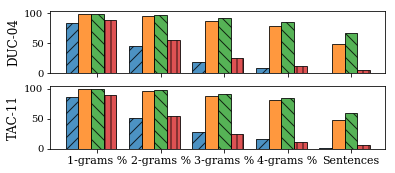

In [69]:
%matplotlib inline
import sys
sys.path.append('/home/logan/Dropbox/Research/multidoc_summarization/src')
import numpy as np
import struct
from tensorflow.core.example import example_pb2
import os
import glob
import tensorflow as tf
import write_data
from absl import flags
from absl import app
import cPickle

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib

matplotlib.rcParams['hatch.linewidth'] = 1.0  # previous pdf hatch linewidth
matplotlib.rcParams['hatch.linewidth'] = 1.0  # previous svg hatch linewidth

# font = {'family' : 'serif',
#         'size'   : 12}
# 
# matplotlib.rc('font', **font)


FLAGS = flags.FLAGS

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

data_dir = '/home/logan/data/multidoc_summarization/tf_examples'
log_dir = '/home/logan/data/multidoc_summarization/logs/'
max_enc_steps = 100000
min_dec_steps = 100
max_dec_steps = 120

# flags.DEFINE_string('exp_name', 'reference', 'Path to system-generated summaries that we want to evaluate.' +
#                            ' If you want to run on human summaries, then enter "reference".')
# flags.DEFINE_string('dataset', 'tac_2011', 'Which dataset to use. Can be {duc_2004, tac_2011, etc}')


def get_nGram(l, n = 2):
    l = list(l)
    return set(zip(*[l[i:] for i in range(n)]))

def get_tf_example(source_file):
    reader = open(source_file, 'rb')
    len_bytes = reader.read(8)
    if not len_bytes: return  # finished reading this file
    str_len = struct.unpack('q', len_bytes)[0]
    example_str = struct.unpack('%ds' % str_len, reader.read(str_len))[0]
    e = example_pb2.Example.FromString(example_str)
    return e

def get_article_text(source_file):
    e = get_tf_example(source_file)
    article_text = e.features.feature['article'].bytes_list.value[
        0].lower()  # the article text was saved under the key 'article' in the data files
    return article_text

def get_summary_text(summary_file, is_reference):
    with open(summary_file) as f:
        summary_text = f.read()
    return summary_text

def get_human_summary_texts(summary_file):
    summary_texts = []
    e = get_tf_example(summary_file)
    for abstract in e.features.feature['abstract'].bytes_list.value:
        summary_texts.append(abstract)  # the abstracts texts was saved under the key 'abstract' in the data files
    return summary_texts

def split_into_tokens(text):
    tokens = text.split()
    tokens = [t for t in tokens if t != '<s>' and t != '</s>']
    return tokens

def split_into_sent_tokens(text):
    sent_tokens = [[t for t in tokens.strip().split() if t != '<s>' and t != '</s>'] for tokens in text.strip().split('\n')]
    return sent_tokens

def limit_to_n_tokens(sent_tokens, n):
    res = []
    count = 0
    for sent in sent_tokens:
        out_sent = []
        for token in sent:
            if count < n:
                out_sent.append(token)
                count += 1
        if len(out_sent) > 0:
            res.append(out_sent)
    return res

def split_by_periods(tokens):
    period_indices = [idx for idx in range(len(tokens)) if tokens[idx] == '.']
    cur_idx = 0
    sents = []
    for period_idx in period_indices:
        sent = tokens[cur_idx:period_idx]
        cur_idx = period_idx + 1
        sents.append(sent)
    # sent = tokens[cur_idx:len(tokens)]
    # sents.append(sent)
    sents = [sent for sent in sents if len(sent) > 0]
    return sents

def does_sent_appear_in_source(sent_tokens, article_tokens):
    len_sent_grams = list(get_nGram(article_tokens, n=len(sent_tokens)))
    return tuple(sent_tokens) in len_sent_grams


def get_ngram_results(article_tokens, summary_tokens):
    ngram_results = []
    for ngram_order in ngram_orders:
        if ngram_order == 'sentence':
            num_appear_in_source = 0
            summary_sent_tokens = split_by_periods(summary_tokens)
            for sent_tokens in summary_sent_tokens:
                if does_sent_appear_in_source(sent_tokens, article_tokens):
                    num_appear_in_source += 1
            percent_appear_in_source = num_appear_in_source * 1. / len(summary_sent_tokens)

        else:
            article_ngrams = get_nGram(article_tokens, n=ngram_order)
            summary_ngrams = get_nGram(summary_tokens, n=ngram_order)
            num_appear_in_source = sum([1 for ngram in list(summary_ngrams) if ngram in article_ngrams])
            percent_appear_in_source = num_appear_in_source * 1. / len(list(summary_ngrams))
        ngram_results.append(percent_appear_in_source)
    return ngram_results

def get_ngram_positions(article_tokens, summary_tokens):
    orders = ngram_orders[:-1]      # don't include sentence-gram
    ngram_positions_for_sent_idx_ngram_order = np.zeros([len(summary_tokens), len(orders)], dtype=float)
    ngram_positions_for_sent_idx = np.zeros([len(summary_tokens)], dtype=float)
    all_ngram_positions_for_sent_idx = [[],[],[],[],[]]
    for summ_sent_idx, summ_sent in enumerate(summary_tokens):
        ngram_positions_for_sent = []
        for ngram_order_idx, ngram_order in enumerate(orders):
            summ_ngrams = get_nGram(summ_sent, n=ngram_order)
            ngram_positions = []
            for ngram in summ_ngrams:
                for art_idx, art_sent in enumerate(article_tokens):
                    art_ngrams = get_nGram(art_sent, n=ngram_order)
                    if ngram in art_ngrams:
                        ngram_positions.append(art_idx)
                        break
            ngram_positions_for_sent.extend(ngram_positions)
            mean_position = np.mean(ngram_positions) if len(ngram_positions) > 0 else -1
            ngram_positions_for_sent_idx_ngram_order[summ_sent_idx, ngram_order_idx] = mean_position
        ngram_positions_for_sent_idx[summ_sent_idx] = np.median(ngram_positions_for_sent)
        if summ_sent_idx < len(all_ngram_positions_for_sent_idx):
            all_ngram_positions_for_sent_idx[summ_sent_idx].extend(ngram_positions_for_sent)
    return ngram_positions_for_sent_idx, ngram_positions_for_sent_idx_ngram_order, all_ngram_positions_for_sent_idx

def plot_ngrams(results):

    datasets = ['duc_2004', 'tac_2011']
    optional_exp_names = ['_reference', '_original', '_reservoir_lambda_0.6_mute_7_tfidf', '_logan']
    pretty_exp_names = ['Human', 'PG-Original', 'PG-MMR', 'Extract+Rewrite']
    # optional_exp_names = ['_reference', '_original', '_reservoir_lambda_0.6_mute_7_tfidf', '_logan', '_original_randomize_sent_order']
    # pretty_exp_names = ['Human', 'PG-Original', 'PG-MMR', 'Extract+Rewrite', 'PG-Original (Rand Input)']

    ind = np.arange(len(ngram_orders))  # the x locations for the groups
    width = 0.2  # the width of the bars

    fig, (ax1, ax2) = plt.subplots(nrows=2)
    plt.subplots_adjust(bottom=0.4, wspace=0.5)

    colors = ['#9E9E9E', '#BDBDBD', '#757575', '#424242']
    axes = [ax1, ax2]
    hatches = ['//', None, '\\\\', '||']
    # hatches = ['//', None, '\\\\', '||', '\\']

    for dataset_idx, dataset in enumerate(datasets):
        exps = [dataset + exp_name for exp_name in optional_exp_names]
        ax = axes[dataset_idx]
        rects = []
        for exp_idx, exp in enumerate(exps):
            values = [val * 100 for val in results[exp]]
            hatch = hatches[exp_idx]
            rect = ax.bar(ind + width*exp_idx, values, width, alpha=0.8, edgecolor='black', hatch=hatch)
            rects.append(rect)


    # ax.set_title('effect of a coverage-based regularizer and beam search with reference')
    ax1.set_ylabel('DUC-04', fontsize=12)
    ax2.set_ylabel('TAC-11', fontsize=12)
    ax1.set_xticks(ind + width * 4 / 2)
    ax2.set_xticks(ind + width * 4 / 2)
    ax1.set_xticklabels(('', '', '', '', ''), fontsize=1)
    ax2.set_xticklabels(('1-grams %', '2-grams %', '3-grams %', '4-grams %', 'Sentences'), fontsize=11)
    print rects, optional_exp_names
    ax2.legend([r[0] for r in rects],
               pretty_exp_names, prop={'size': 11}, ncol=2,
               edgecolor='black', loc='upper center', bbox_to_anchor=(0.5, -0.3), shadow=False)

    ax1.set_ylim([0, 105])
    ax2.set_ylim([0, 105])

    pp = PdfPages('ngram_percentages.pdf')
    plt.savefig(pp, format='pdf')
    
    pp.close()




ngram_orders = [1, 2, 3, 4, 'sentence']


def main(unused_argv):

    datasets = ['duc_2004', 'tac_2011']
    optional_exp_names = ['_reference', '_original', '_reservoir_lambda_0.6_mute_7_tfidf', '_logan']
    # optional_exp_names = ['_reference', '_original', '_reservoir_lambda_0.6_mute_7_tfidf', '_logan', '_original_randomize_sent_order']

    results_path = '/home/logan/data/multidoc_summarization/ngram_results.pkl'
    if os.path.exists(results_path):
        with open(results_path, 'rb') as f:
            extractiveness_results = cPickle.load(f)
    else:
        extractiveness_results = {}
        for dataset in datasets:
            for optional_exp_name in optional_exp_names:
                exp_name = dataset + optional_exp_name


                print 'Running statistics on %s' % exp_name

                if len(unused_argv) != 1: # prints a message if you've entered flags incorrectly
                    raise Exception("Problem with flags: %s" % unused_argv)
                # original_dir = dec_dir.split('/')
                # original_dir[-1] = 'reference'
                # rouge_ref_dir = '/'.join(original_dir)

                source_dir = os.path.join(data_dir, dataset)
                if exp_name == dataset + '_reference':
                    summary_dir = source_dir
                    is_reference = True
                else:
                    summary_dir = log_dir + exp_name + '/decode_test_' + str(max_enc_steps) + \
                                    'maxenc_4beam_' + str(min_dec_steps) + 'mindec_' + str(max_dec_steps) + 'maxdec_ckpt-238410/decoded'
                    is_reference = False
                print('Ngrams ', ngram_orders, ' appearing in source documents')


                ngram_percentages = []

                summary_files = sorted(glob.glob(summary_dir + '/*'))
                if len(summary_files) == 0:
                    raise Exception('No files found in %s' % summary_dir)
                source_files = sorted(glob.glob(source_dir + '/*'))
                for file_idx in range(len(summary_files)):
                    example = get_tf_example(source_files[file_idx])
                    article_text = example.features.feature['article'].bytes_list.value[0].lower()
                    article_tokens = split_into_tokens(article_text)
                    raw_article_sents = example.features.feature['raw_article_sents'].bytes_list.value
                    article_sent_tokens = [write_data.process_sent(sent) for sent in raw_article_sents]


                    if is_reference:
                        all_ngram_results = []
                        human_summary_texts = get_human_summary_texts(summary_files[file_idx])
                        for summary_text in human_summary_texts:
                            summary_tokens = split_into_tokens(summary_text)
                            ngram_results = get_ngram_results(article_tokens, summary_tokens)
                            all_ngram_results.append(ngram_results)
                        all_ngram_results = np.array(all_ngram_results)
                        average_ngram_results = np.mean(all_ngram_results, axis=0)
                        ngram_percentages.append(average_ngram_results)
                    else:
                        summary_text = get_summary_text(summary_files[file_idx], is_reference)
                        summary_tokens = split_into_tokens(summary_text)
                        summary_tokens = summary_tokens[:100]

                        ngram_results = get_ngram_results(article_tokens, summary_tokens)
                        ngram_percentages.append(ngram_results)

                    a=0

                print 'Experiment name: ', exp_name
                average_percents = []
                for ngram_idx in range(len(ngram_orders)):
                    average_percent = sum([tup[ngram_idx] for tup in ngram_percentages]) / len(ngram_percentages)
                    print '%.4f\t' % average_percent,
                    average_percents.append(average_percent)
                print '\n'

                extractiveness_results[exp_name] = average_percents

        with open(results_path, 'wb') as f:
            cPickle.dump(extractiveness_results, f)

    plot_ngrams(extractiveness_results)

    a=0



    datasets = ['duc_2004', 'tac_2011']
    optional_exp_names = ['_original', '_original_randomize_sent_order', '_reservoir_lambda_0.6_mute_7_tfidf']

    results_path = '/home/logan/data/multidoc_summarization/position_results.pkl'
    if os.path.exists(results_path):
        with open(results_path, 'rb') as f:
            position_results = cPickle.load(f)
    else:
        position_results = {}

        for dataset in datasets:
            for optional_exp_name in optional_exp_names:
                if optional_exp_name == 'reference':
                    exp_name = 'reference'
                else:
                    exp_name = dataset + optional_exp_name

                print 'Running statistics on %s' % exp_name

                source_dir = os.path.join(data_dir, dataset)
                if exp_name == 'reference':
                    summary_dir = source_dir
                    is_reference = True
                else:
                    summary_dir = log_dir + exp_name + '/decode_test_' + str(max_enc_steps) + \
                                    'maxenc_4beam_' + str(min_dec_steps) + 'mindec_' + str(max_dec_steps) + 'maxdec_ckpt-238410/decoded'
                    is_reference = False


                all_ngram_positions = []
                all_ngram_positions_sent_ngram = []
                all_all_ngram_positions_for_sent_idx = [[],[],[],[],[]]

                summary_files = sorted(glob.glob(summary_dir + '/*'))
                if len(summary_files) == 0:
                    raise Exception('No files found in %s' % summary_dir)
                source_files = sorted(glob.glob(source_dir + '/*'))
                for file_idx in range(len(summary_files)):
                    example = get_tf_example(source_files[file_idx])
                    article_text = example.features.feature['article'].bytes_list.value[0].lower()
                    summary_text = get_summary_text(summary_files[file_idx], is_reference)
                    article_tokens = split_into_tokens(article_text)
                    raw_article_sents = example.features.feature['raw_article_sents'].bytes_list.value
                    article_sent_tokens = [write_data.process_sent(sent) for sent in raw_article_sents]
                    summary_sent_tokens = split_into_sent_tokens(summary_text)
                    summary_sent_tokens = limit_to_n_tokens(summary_sent_tokens, 100)


                    ngram_positions, ngram_positions_sent_ngram, all_ngram_positions_for_sent_idx = get_ngram_positions(
                        article_sent_tokens, summary_sent_tokens)
                    all_ngram_positions.append(ngram_positions)
                    all_ngram_positions_sent_ngram.append(ngram_positions_sent_ngram)
                    for sent_idx, sent_positions in enumerate(all_ngram_positions_for_sent_idx):
                        all_all_ngram_positions_for_sent_idx[sent_idx].extend(sent_positions)

                sent_indices = [0,1,2,3,4]
                print 'Ngram positions for sents', sent_indices

                print 'Mean:\t',
                for positions in all_all_ngram_positions_for_sent_idx:
                    print '%.1f\t' % np.mean(positions),
                print '\n25 perc:\t',
                for positions in all_all_ngram_positions_for_sent_idx:
                    print '%.1f\t' % np.percentile(positions, 25),
                print '\n50 perc:\t',
                for positions in all_all_ngram_positions_for_sent_idx:
                    print '%.1f\t' % np.percentile(positions, 50),
                print '\n75 perc:\t',
                for positions in all_all_ngram_positions_for_sent_idx:
                    print '%.1f\t' % np.percentile(positions, 75),
                print '\n',

                exp_results = []
                for positions in all_all_ngram_positions_for_sent_idx:
                    exp_results.append((np.percentile(positions, 25), np.percentile(positions, 50), np.percentile(positions, 75)))
                position_results[exp_name] = exp_results
        with open(results_path, 'wb') as f:
            cPickle.dump(position_results, f)
    plot_positions(position_results)
    a=0

main([])



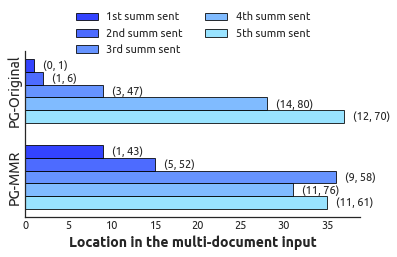

In [94]:


def label_barh(ax, bars, texts, is_inside=True, **kwargs):
    """
    Attach a text label to each horizontal bar displaying its y value
    """
    max_y_value = max(bar.get_height() for bar in bars)
    if is_inside:
        distance = max_y_value * 1
    else:
        distance = max_y_value * 7


    for bar_idx, bar in enumerate(bars):
        text = texts[bar_idx]
        if is_inside:
            text_x = bar.get_width() - distance
        else:
            text_x = bar.get_width() + distance
        text_y = bar.get_y() + bar.get_height() / 2

        ax.text(text_x, text_y, text, va='center', **kwargs)

def plot_positions(results):
    datasets = ['tac_2011']
    optional_exp_names = ['_original', '_reservoir_lambda_0.6_mute_7_tfidf']
    pretty_exp_names = ['PG-Original', 'PG-MMR']
    pretty_sent_indices = ['1st summ sent', '2nd summ sent', '3rd summ sent', '4th summ sent', '5th summ sent']

    ind = np.arange(2)[::-1]  # the x locations for the groups
    width = 0.15  # the width of the bars
    interval = np.arange(5) * 0.2

    fig, ax1 = plt.subplots(nrows=1)
    plt.subplots_adjust(top=0.7, wspace=0.5, hspace=0.5)

    colors = ['#9E9E9E', '#BDBDBD', '#757575', '#424242', '#424245']
    colors = ['#0014FF', '#2046FF', '#4078FF', '#60AAFF', '#80DCFF']
    axes = [ax1]
    hatches = ['//', '\\\\', '||', '/', '\\']

    for dataset_idx, dataset in enumerate(datasets):
        exps = [dataset + exp_name for exp_name in optional_exp_names]
        ax = axes[dataset_idx]
        rects = []
        for sent_idx in range(5):
            medians = [results[exp][sent_idx][1] for exp in exps]
            ci_texts = ['(' + str(int(results[exp][sent_idx][0])) + ', ' +
                        str(int(results[exp][sent_idx][2])) + ')' for exp in exps]
            # ci = [[val[1] - val[0] for val in values], [val[2] - val[1] for val in values]]
            hatch = hatches[sent_idx]
            rect = ax.barh(ind - width * sent_idx, medians, height=width, color=colors[sent_idx],
                           alpha=0.8, edgecolor='black', hatch=None, capsize=2.5)
            label_barh(ax, rect, ci_texts, is_inside=False, fontsize=11)
            rects.append(rect)

    ax1.set_xlabel('Location in the multi-document input')
    ax1.set_yticks(ind - width * 4 / 2)
    ax1.set_yticklabels(pretty_exp_names, rotation='vertical', fontdict={'verticalalignment': 'center'})
    # print rects, optional_exp_names
    ax1.legend([r[0] for r in rects],
               pretty_sent_indices, prop={'size': 11}, ncol=2,
               edgecolor='black', loc='upper center', bbox_to_anchor=(0.5, 1.3), shadow=False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    pp = PdfPages('sent_positions.pdf')
    plt.savefig(pp, format='pdf',bbox_inches='tight')
    plt.show()
    pp.close()

plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 14

results_path = '/home/logan/data/multidoc_summarization/position_results.pkl'
with open(results_path, 'rb') as f:
    position_results = cPickle.load(f)
plot_positions(position_results)